In [6]:
! wget https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip
! wget https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip

--2023-07-18 18:51:23--  https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 142.251.175.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  23.3MB/s    in 7.4s    

2023-07-18 18:51:30 (19.3 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2023-07-18 18:51:30--  https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 142.251.175.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [appl

In [7]:
! unzip -xq '/content/horse-or-human.zip' -d '/content/training'
! unzip -xq '/content/validation-horse-or-human.zip' -d '/content/validation'

In [1]:
import numpy as np
import pandas as pd
from keras import Sequential

In [2]:
humans = '/content/humans'
horses = '/content/horses'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    rescale = 1/255,
    rotation_range = 25,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    zoom_range=0.15,
)

test_datagen = ImageDataGenerator(
    horizontal_flip = True,
    rescale = 1/255,
)

In [4]:
train_dir = '/content/training'
validation_dir = '/content/validation'

In [8]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size = 128,
    class_mode = 'binary',
    target_size = (160, 160),
)

test_generator = test_datagen.flow_from_directory(
    directory=validation_dir,
    batch_size = 128,
    class_mode = 'binary',
    target_size = (160, 160)

)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [9]:
a = next(train_generator)

In [10]:
type(a)

tuple

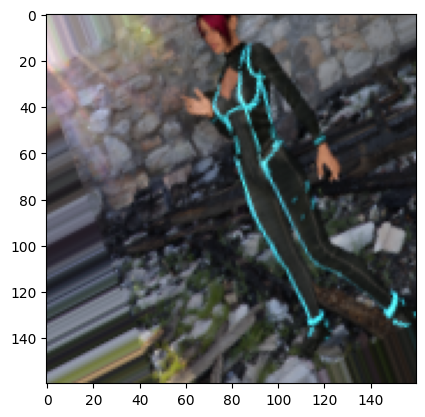

In [11]:
import matplotlib.pyplot as plt

plt.imshow(a[0][2])

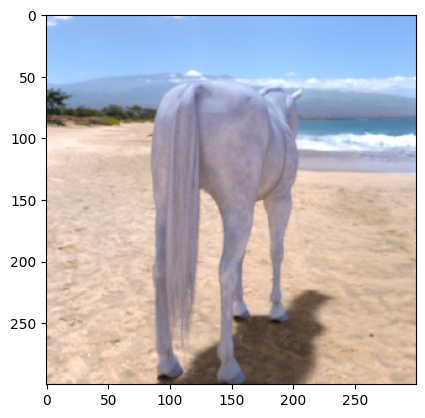

In [12]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread('/content/training/horses/horse01-5.png')[:, :, ::-1]
img = np.expand_dims(img, axis=0)
plt.imshow(img[0])

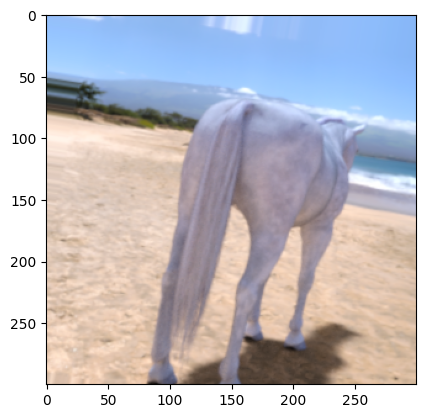

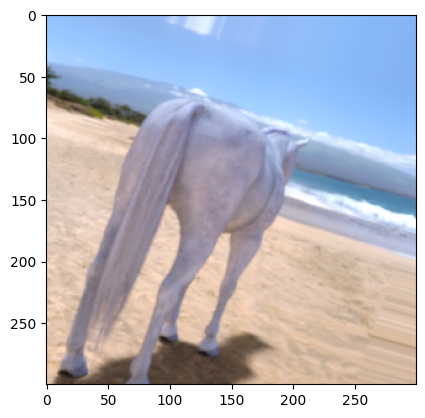

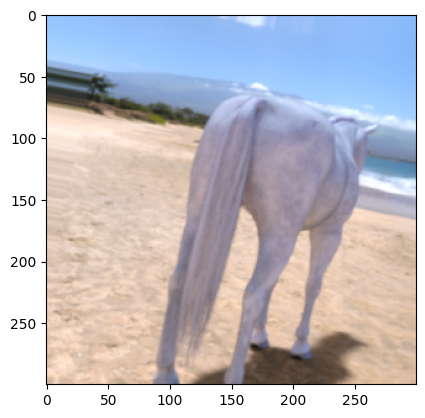

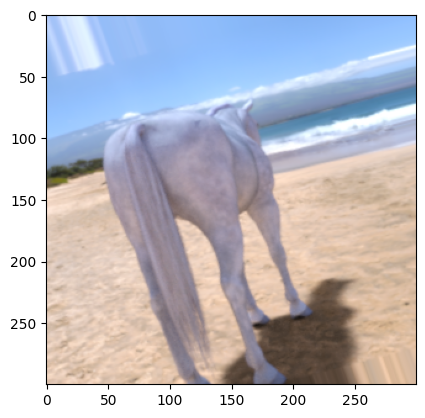

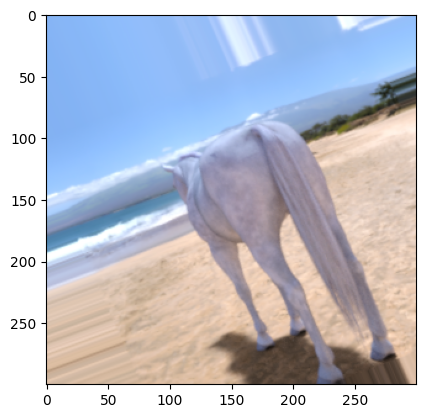

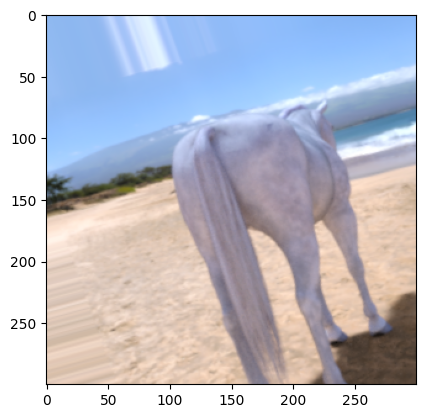

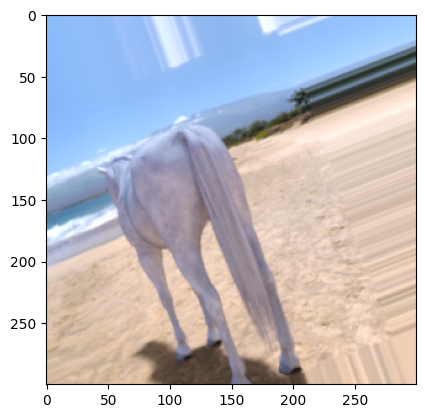

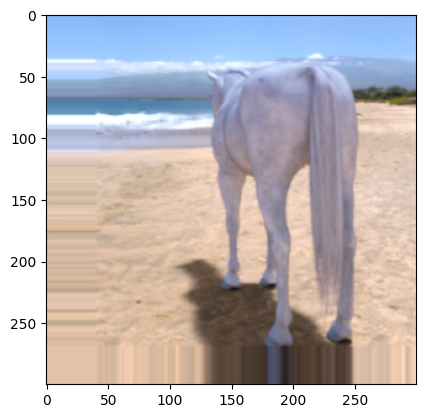

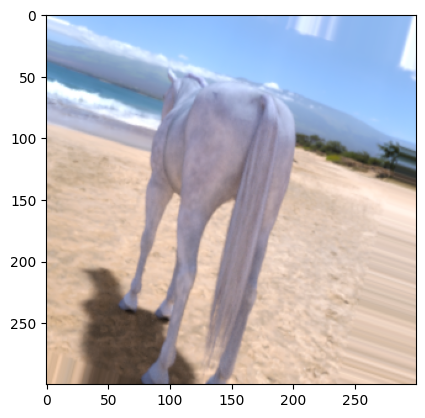

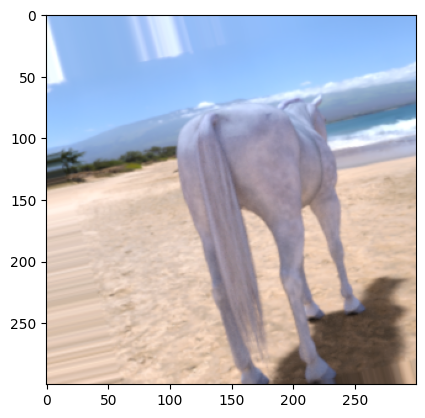

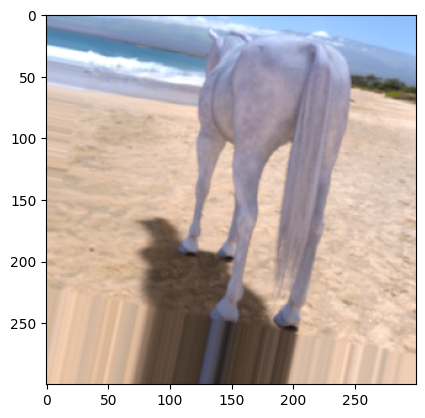

In [13]:
c = 0
for batch in train_datagen.flow(x=img, batch_size=1):
    plt.imshow(batch[0])
    c += 1
    plt.show()
    if c>10:
        break

In [14]:
from keras.applications import MobileNetV2

In [15]:
mobile_net = MobileNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (160, 160, 3),
    pooling = max,

)

9406464/9406464 [==============================] - 1s 0us/step


In [16]:
mobile_net.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [17]:
for layer in mobile_net.layers:
    layer.trainable = False

In [18]:
last_layer = mobile_net.get_layer('out_relu')
last_output = last_layer.output

In [19]:
from keras.layers import Flatten, Dense, Dropout

x = Flatten()(last_output)
x = Dense(activation='relu', units=64)(x)
x = Dropout(0.2)(x)
out_x = Dense(1, activation='sigmoid')(x)

In [20]:
from keras.models import Model
model = Model(mobile_net.input, out_x)

In [21]:
from keras.optimizers import RMSprop, Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='BinaryCrossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

In [23]:
import tensorflow as tf

checkpoint_path = 'content/models/best.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor='val_accuracy',
    save_weights_only = False,
    save_best_only = True,
    verbose = 1

)

In [24]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=128,
                    verbose=1,
                    validation_data=test_generator,
                    callbacks=[callback])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9133
Epoch 1: val_accuracy improved from -inf to 0.99609, saving model to content/models/best.h5
9/9 [==============================] - 26s 2s/step - loss: 0.2221 - accuracy: 0.9133 - val_loss: 0.0092 - val_accuracy: 0.9961
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9961
Epoch 2: val_accuracy improved from 0.99609 to 1.00000, saving model to content/models/best.h5
9/9 [==============================] - 14s 2s/step - loss: 0.0331 - accuracy: 0.9961 - val_loss: 1.7856e-04 - val_accuracy: 1.0000
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9951
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 13s 1s/step - loss: 0.0530 - accuracy: 0.9951 - val_loss: 4.0473e-09 - val_accuracy: 1.0000
Epoch 4/30
8/9 [=========================>....] - ETA: 1s - loss: 0.0707 - accuracy: 0.9961
Epoch

In [25]:
model.evaluate(train_generator)

9/9 [==============================] - 12s 1s/step - loss: 0.0193 - accuracy: 0.9990


[0.01925693079829216, 0.9990262985229492]

In [26]:
model.evaluate(test_generator)

2/2 [==============================] - 1s 451ms/step - loss: 6.5866e-08 - accuracy: 1.0000


[6.586616052572936e-08, 1.0]

In [27]:
pred = model.predict(test_generator)

2/2 [==============================] - 2s 435ms/step


Text(0.5, 1.0, 'Training and validation loss')

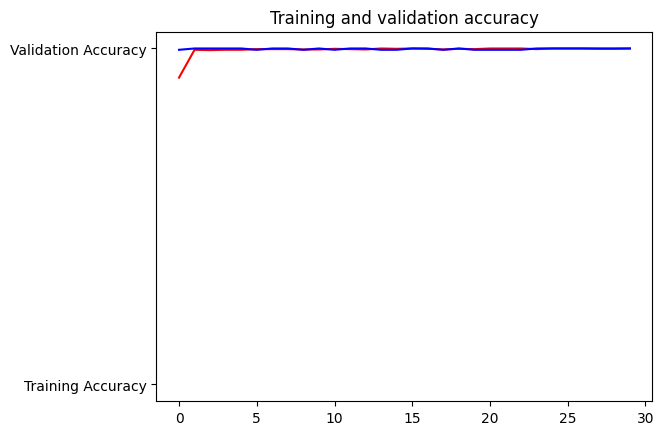

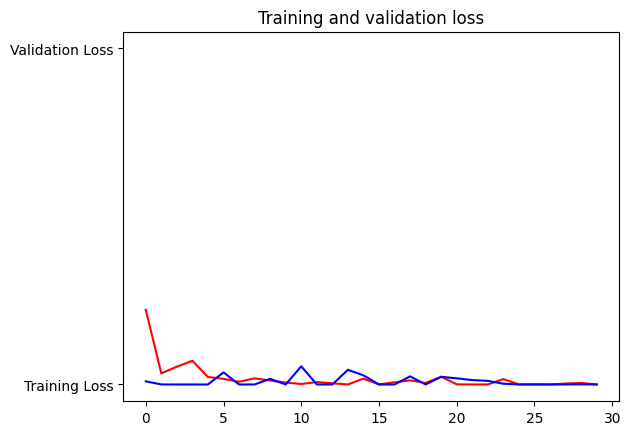

In [28]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(160,160))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.
    classes = model.predict(x, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")